In [1]:
import tensorflow as tf
import os
import numpy as np
import pickle
import random
import scipy.misc as smp

In [2]:
RANDOM_VEC_SIZE = 100

SIZE = 32
CLASSES = 10
CHANNELS = 3

RUN_NAME = random.randint(0, 10000)
print("Current Run: " + str(RUN_NAME))

Current Run: 7450


In [3]:
data_path = "data/cifar"

def read_data(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict
def reorder(img):
    return np.transpose(np.reshape(img, (3, 32, 32)), (1,2,0)).reshape((len(img)))
def load_data():
    train_data_path = data_path + "/data_batch_"
    test_data_path = data_path + "/test_batch"
    
    train_data = read_data(train_data_path + "1")
    
    train_images = train_data[b'data']
    train_labels = train_data[b'labels']
    for i in range(2, 6):
        batch_data = read_data(train_data_path + str(i))
        
        train_images = np.concatenate((train_images, batch_data[b'data']))
        train_labels = np.concatenate((train_labels, batch_data[b'labels']))
        
    test_data = read_data(test_data_path)
    
    #train_images = [tf.image.per_image_standardization(np.reshape(img, [SIZE, SIZE, CHANNELS])) for img in train_images]
    #train_images = [tf.reshape(img, [SIZE, SIZE, CHANNELS]) for img in train_images]
    
    for i in range(len(train_images)):
        train_images[i] = reorder(train_images[i]).reshape((SIZE**2 * CHANNELS))

    return train_images, train_labels, test_data

In [4]:
train_images, train_labels, test_data = load_data()

#test_images = test_data[b'data']
#test_labels = test_data[b'labels']

print(len(train_images))

50000


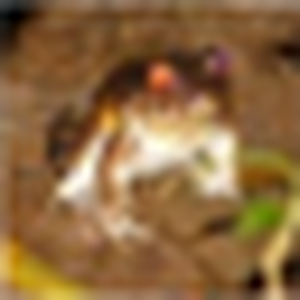

In [5]:
from PIL import Image 

def display_img(data):
    img = np.reshape(data, (SIZE,SIZE,CHANNELS))
    return Image.fromarray(img.astype("uint8")).resize((300,300), Image.ANTIALIAS)

display_img(train_images[0])

In [6]:
sess = tf.InteractiveSession()

In [7]:
def generator(z, is_train=True, out_channel_dim=3):
    alpha = 0.2
    fc_size = 512
    
    def deconv(net, printVal=True):
        side_len = net.shape[3] // 2
        
        deconv = tf.layers.conv2d_transpose(net, side_len, 5, 2, padding="SAME")
        batch_norm = tf.layers.batch_normalization(deconv, training=is_train)
        lrelu = tf.nn.leaky_relu(batch_norm, alpha)
        
        if printVal:
            print(str(lrelu.shape))
        
        return lrelu
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        print("GENERATOR")
        fc_1 = tf.layers.dense(z, fc_size * (SIZE//16)**2)
        fc_1 = tf.reshape(fc_1, [-1, SIZE//16, SIZE//16, fc_size])
        batch_norm_1 = tf.layers.batch_normalization(fc_1, training=is_train)
        net = tf.nn.leaky_relu(batch_norm_1, alpha)
        
        net = deconv(net)
        net = deconv(net)
        net = deconv(net)        
        
        logits = tf.layers.conv2d_transpose(net, out_channel_dim, 5, 2, padding="SAME")
        print("Final Shape: " + str(logits.shape))
        
        return tf.tanh(logits)

In [8]:
def discrim(images, reuse=False, is_train=True, num_channels=3):
    alpha = 0.2
    
    def conv(net, printVal=True):
        size = net.shape[3] * 2
        
        conv = tf.layers.conv2d(net, size, 5, 2, "SAME")
        batch_norm = tf.layers.batch_normalization(conv, training=is_train)
        lrelu = tf.nn.leaky_relu(batch_norm, alpha)
        
        print(lrelu.shape)
        return lrelu
    #I have no idea why the variable naming convention suddenly changed here
    with tf.variable_scope("discrim", reuse=reuse):
        print("DISCRIM")
        conv1 = tf.layers.conv2d(images, 64, 5, 2, "SAME")
        net = tf.nn.leaky_relu(conv1, alpha)
        
        net = conv(net)
        net = conv(net)
        net = conv(net)
        
        size = net.shape[1] * net.shape[2] * net.shape[3]
        net = tf.reshape(net, [-1, size])
        
        logits = tf.layers.dense(net, 1)
        
        return logits, tf.sigmoid(logits)  
        

In [9]:
def model_loss(input_real, input_z, num_channels=3):
    label_smoothing = 0.9
    
    fake_out = generator(input_z)
    G_sample_image = tf.summary.image("Deep_GAN{}".format(RUN_NAME), fake_out)
    
    real_logits, real_probs = discrim(tf.reshape(input_real, [-1, SIZE, SIZE, num_channels]))
    fake_logits, fake_probs = discrim(fake_out, True)
    
    D_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=label_smoothing * tf.ones_like(real_logits)))
    D_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    D_accur = (tf.reduce_mean(tf.round(real_probs)) + tf.reduce_mean(tf.round(1 - fake_probs))) / 2
    
    D_loss = D_loss_real + D_loss_fake
    
    G_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=label_smoothing * tf.ones_like(fake_logits)))
    
    return D_loss, D_accur, G_loss

In [10]:
def opt(D_loss, G_loss, learning_rate, beta1, weight_decay=0.01):
    t_vars = tf.trainable_variables()
    
    D_loss += tf.add_n([tf.nn.l2_loss(var) for var in t_vars if var.name.startswith("discrim")]) * weight_decay
    d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
        D_loss, var_list=[var for var in t_vars if var.name.startswith("discrim")])
    
    
    G_loss += tf.add_n([tf.nn.l2_loss(var) for var in t_vars if var.name.startswith("generator")]) * weight_decay
    g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
        G_loss, var_list=[var for var in t_vars if var.name.startswith("generator")])
    
    return d_train, g_train

In [11]:
Z = tf.placeholder(tf.float32, [None, RANDOM_VEC_SIZE])
X = tf.placeholder(tf.float32, [None, SIZE**2 * CHANNELS])


D_loss, D_accur, G_loss = model_loss(X, Z)

tf.summary.scalar("D_loss{}".format(RUN_NAME), D_loss)
tf.summary.scalar("G_loss{}".format(RUN_NAME), G_loss)

all_summaries = tf.summary.merge_all()
D_trainer, G_trainer = opt(D_loss, G_loss, 0.0002, 0.5)

GENERATOR
(?, 4, 4, 256)
(?, 8, 8, 128)
(?, 16, 16, 64)
Final Shape: (?, 32, 32, 3)
DISCRIM
(?, 8, 8, 128)
(?, 4, 4, 256)
(?, 2, 2, 512)
DISCRIM
(?, 8, 8, 128)
(?, 4, 4, 256)
(?, 2, 2, 512)


In [12]:
def sample_Z(batch_size):
    return np.random.uniform(-1, 1, [batch_size, RANDOM_VEC_SIZE])

np.random.seed(0xDEADBEEF)

In [13]:
tf.global_variables_initializer().run()

summary_writer = tf.summary.FileWriter("tmp/logs", sess.graph)

In [14]:
def generate_data(batch_size):
    indices = np.random.randint(0, len(train_images), [batch_size])
    return [np.divide(train_images[i].astype(np.float32), 256) for i in indices], [train_labels[i] for i in indices]

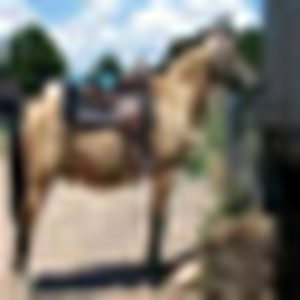

In [15]:
display_img(np.multiply(generate_data(1)[0][0], 256))

In [16]:
BATCH_SIZE = 128
FAKE_BATCH_SIZE = 128

DISCR_ITERS = 2
GEN_ITERS = 1

for ITER in range(1000000):
    
    for _ in range(DISCR_ITERS):
        batch, _ = generate_data(BATCH_SIZE)
        fake_batch = sample_Z(FAKE_BATCH_SIZE)
        D_trainer.run(feed_dict={Z: fake_batch, X: batch})
    for _ in range(GEN_ITERS):
        batch, _ = generate_data(BATCH_SIZE)
        fake_batch = sample_Z(FAKE_BATCH_SIZE)
        G_trainer.run(feed_dict={Z: fake_batch, X: batch})
    
    if ITER % 100 == 0:
            
        batch, _ = generate_data(BATCH_SIZE)
        fake_batch = sample_Z(FAKE_BATCH_SIZE)
        
        D_train_loss, G_train_loss, D_train_accur, summary = sess.run([D_loss, G_loss, D_accur, all_summaries], 
                                                                      feed_dict={Z: fake_batch, X: batch})

        print("Iter %05d: Losses: %.2f and %.2f | Accur: %.2f%%"%(ITER, D_train_loss, G_train_loss, 100 * D_train_accur))

        summary_writer.add_summary(summary, ITER)
        summary_writer.flush()

Iter 00000: Losses: 1.10 and 1.38 | Accur: 89.45%
Iter 00100: Losses: 1.50 and 1.10 | Accur: 69.53%
Iter 00200: Losses: 0.55 and 2.22 | Accur: 100.00%
Iter 00300: Losses: 0.41 and 2.92 | Accur: 100.00%
Iter 00400: Losses: 0.49 and 2.13 | Accur: 99.61%
Iter 00500: Losses: 0.36 and 4.60 | Accur: 99.61%
Iter 00600: Losses: 0.57 and 1.73 | Accur: 99.61%
Iter 00700: Losses: 0.40 and 2.74 | Accur: 100.00%
Iter 00800: Losses: 0.45 and 2.26 | Accur: 100.00%
Iter 00900: Losses: 0.48 and 2.61 | Accur: 100.00%
Iter 01000: Losses: 0.47 and 2.31 | Accur: 100.00%
Iter 01100: Losses: 0.79 and 1.20 | Accur: 92.97%
Iter 01200: Losses: 0.50 and 1.89 | Accur: 99.61%
Iter 01300: Losses: 0.39 and 3.03 | Accur: 100.00%
Iter 01400: Losses: 0.43 and 3.30 | Accur: 98.83%
Iter 01500: Losses: 0.52 and 1.76 | Accur: 100.00%
Iter 01600: Losses: 0.49 and 2.00 | Accur: 100.00%
Iter 01700: Losses: 0.45 and 2.59 | Accur: 100.00%
Iter 01800: Losses: 0.41 and 2.74 | Accur: 100.00%
Iter 01900: Losses: 0.47 and 2.16 | Acc

Iter 16300: Losses: 0.43 and 2.52 | Accur: 99.61%
Iter 16400: Losses: 0.43 and 2.85 | Accur: 100.00%
Iter 16500: Losses: 0.47 and 2.25 | Accur: 100.00%
Iter 16600: Losses: 0.55 and 1.68 | Accur: 100.00%
Iter 16700: Losses: 0.40 and 2.51 | Accur: 100.00%
Iter 16800: Losses: 0.40 and 2.65 | Accur: 100.00%
Iter 16900: Losses: 0.50 and 3.35 | Accur: 98.05%
Iter 17000: Losses: 0.76 and 1.62 | Accur: 91.80%
Iter 17100: Losses: 0.45 and 2.31 | Accur: 100.00%
Iter 17200: Losses: 0.38 and 2.82 | Accur: 100.00%
Iter 17300: Losses: 0.44 and 2.95 | Accur: 100.00%
Iter 17400: Losses: 0.99 and 0.78 | Accur: 81.25%
Iter 17500: Losses: 0.37 and 3.66 | Accur: 100.00%
Iter 17600: Losses: 0.42 and 3.56 | Accur: 99.61%
Iter 17700: Losses: 2.99 and 0.34 | Accur: 50.00%
Iter 17800: Losses: 0.49 and 1.85 | Accur: 100.00%
Iter 17900: Losses: 1.13 and 0.65 | Accur: 67.97%
Iter 18000: Losses: 0.46 and 2.07 | Accur: 100.00%
Iter 18100: Losses: 0.42 and 2.39 | Accur: 100.00%
Iter 18200: Losses: 0.49 and 1.86 | Ac

KeyboardInterrupt: 